<a href="https://colab.research.google.com/github/vlad98rus/-netology_pyda/blob/HomeWork-1/DZ_Ensemble_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Ансамблирование»






1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [0]:
RANDOM_STATE = 7
N_FOLDS = 10

In [0]:
data = pd.read_csv('train.csv')

In [6]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Разбиваем нашу модель на train и test

In [0]:
d_train, d_test, y_train, y_test = train_test_split(data.drop('SalePrice',axis=1), data.SalePrice, random_state=RANDOM_STATE, test_size=0.2)

In [8]:
d_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1087,1088,60,FV,85.0,10574,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,Unf,0,Unf,0,1082,1082,GasA,Ex,Y,SBrkr,1082,871,0,1953,0,0,2,1,3,1,Gd,9,Typ,1,Gd,Attchd,2005.0,RFn,3,1043,TA,TA,Y,160,50,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
187,188,50,RL,60.0,10410,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,7,1916,1987,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,660,660,GasA,Ex,Y,SBrkr,808,704,144,1656,0,0,2,1,3,1,TA,8,Min2,0,NaN,Detchd,1916.0,Unf,1,180,Fa,Fa,N,0,0,0,140,0,0,NaN,MnPrv,NaN,0,8,2009,WD,Normal
671,672,70,RH,54.0,6629,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,2Story,6,6,1925,1950,Gambrel,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,BLQ,551,Unf,0,121,672,GasA,TA,N,SBrkr,697,672,0,1369,1,0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1930.0,Unf,1,300,TA,TA,Y,147,0,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
652,653,60,RL,70.0,8750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1996,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,880,880,GasA,Ex,Y,SBrkr,909,807,0,1716,0,0,2,1,2,1,Gd,7,Typ,1,TA,Attchd,1996.0,RFn,2,512,TA,TA,Y,0,120,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
1266,1267,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,2fmCon,2.5Unf,7,4,1910,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,925,925,GasA,TA,N,FuseF,964,925,0,1889,0,0,1,1,4,2,TA,9,Typ,1,Gd,Detchd,1960.0,Unf,1,308,TA,TA,N,0,0,264,0,0,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal


На данном этапе необходимо найти категориальные признаки.

In [0]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

Выявляем пропущенные значения, но не удаляем их, вставим вместо пустого места NAN. Поскольку в данном случае это может дать нам более корректную работу.

In [0]:
data[cat_feat] = data[cat_feat].fillna('nan')

Отфильтруем наши данные

In [0]:
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]

Неоходимо узнать сколько у нас уникальных значений по каждому признаку.

In [12]:
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      15
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         4
CentralAir        2
Electrical        5
KitchenQual       4
Functional        6
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


Создаем переменные для категорий

In [0]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

Заменяем пропуски на специальное значение -9999, чтобы деревья могли их отличить

In [0]:
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [15]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,CentralAir_Y,MasVnrType_BrkFace,Electrical_SBrkr,GarageCond_TA,...,RoofStyle_Mansard,Exterior1st_CemntBd,BsmtFinType2_LwQ,MasVnrType_None,LandContour_HLS,Functional_Typ,Neighborhood_NPkVill,Neighborhood_NridgHt,MSZoning_RM,GarageQual_Fa,Neighborhood_ClearCr,Exterior2nd_BrkFace,Neighborhood_BrDale,Exterior2nd_Stucco,HouseStyle_SLvl,MSZoning_RL,ExterCond_Gd,SaleCondition_Abnorml,LandContour_Low,GarageQual_TA,MSZoning_FV,Street_Pave,Exterior1st_MetalSd,BsmtFinType1_LwQ,BsmtFinType2_ALQ,GarageFinish_RFn,Neighborhood_Somerst,RoofMatl_WdShngl,Condition2_Norm,Foundation_CBlock,BldgType_Duplex,BsmtQual_Fa,BsmtExposure_Av,HouseStyle_SFoyer,Fence_MnWw,LandSlope_Mod,BsmtExposure_Gd,Neighborhood_BrkSide,LotShape_Reg,GarageType_Detchd
1087,60,85.0,10574,8,5,2005,2006,0.0,0,0,1082,1082,1082,871,0,1953,0,0,2,1,3,1,9,1,2005.0,3,1043,160,50,0,0,0,0,0,5,2009,1,0,1,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0
187,50,60.0,10410,5,7,1916,1987,0.0,0,0,660,660,808,704,144,1656,0,0,2,1,3,1,8,0,1916.0,1,180,0,0,0,140,0,0,0,8,2009,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1
671,70,54.0,6629,6,6,1925,1950,0.0,551,0,121,672,697,672,0,1369,1,0,2,0,3,1,6,0,1930.0,1,300,147,0,0,0,0,0,0,7,2009,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
652,60,70.0,8750,7,5,1996,1996,0.0,0,0,880,880,909,807,0,1716,0,0,2,1,2,1,7,1,1996.0,2,512,0,120,0,0,0,0,0,7,2009,1,0,1,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1266,190,60.0,10120,7,4,1910,1950,0.0,0,0,925,925,964,925,0,1889,0,0,1,1,4,2,9,1,1960.0,1,308,0,0,264,0,0,0,0,1,2007,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1


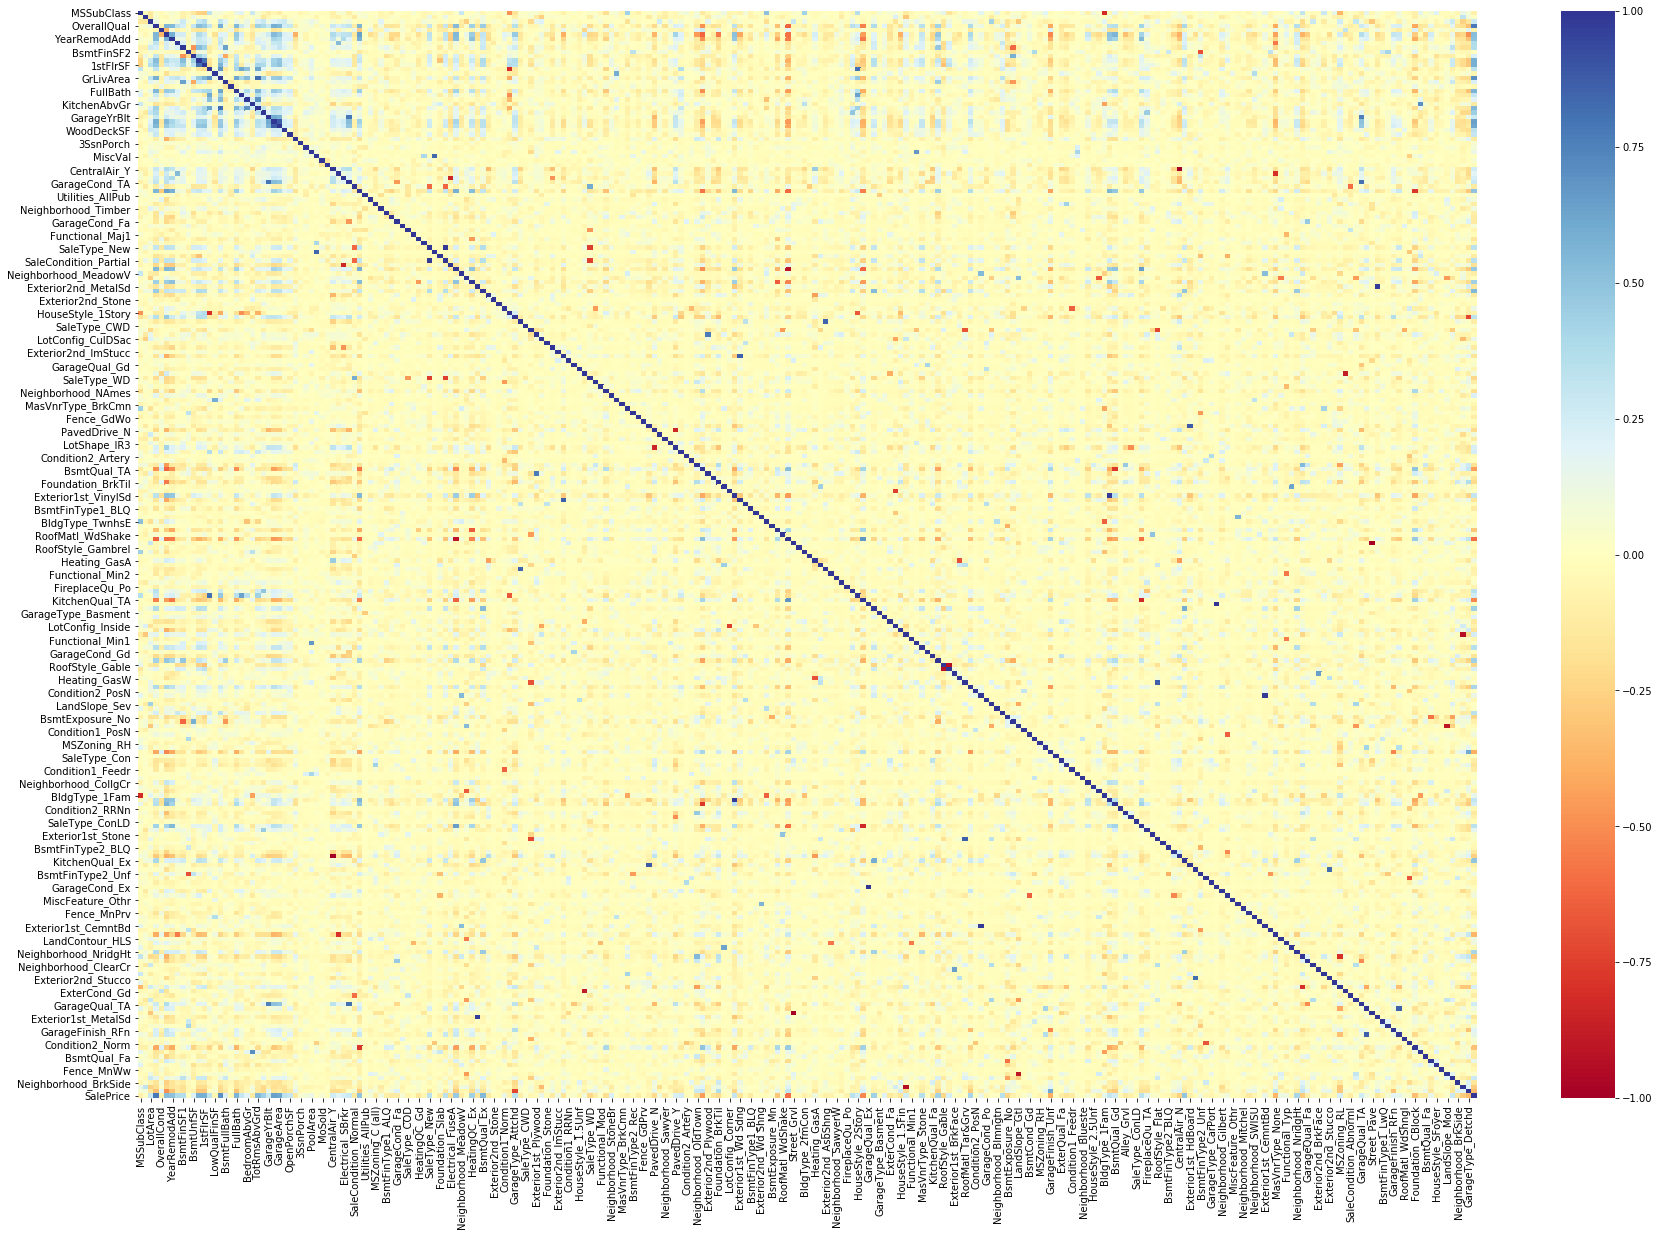

In [17]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(pd.concat([X_train,y_train], axis=1).corr(),annot=False,cmap="RdYlBu");

In [18]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, bootstrap=True, random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [19]:
print(f"MSE = {np.mean(-cross_val_score(model_rf,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 2254747577.277308


#### Отобразим графически важные признаки нашей модели.

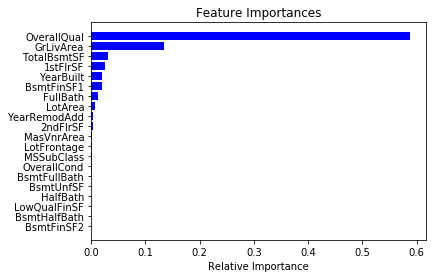

In [20]:
features = X_train.columns
importances = model_rf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Применяем линейную регрессию

In [0]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_lin[num_feat])

X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])

In [22]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train_lin, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 4777025491.477309


### Импортируем и обучаем XGBoost

In [25]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
print(model)
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0      177732.994792     3496.224952   177833.588542    7482.525922
1      161357.473958     3258.920819   161737.453125    7458.197242
2      146696.494792     3071.496224   147286.619792    7242.954520
3      133528.263021     2920.403942   134085.231771    7430.342661
4      121720.877604     2739.860451   122335.669271    7560.694123
..               ...             ...             ...            ...
495      9301.893880      264.627383    26855.327474    4418.956776
496      9291.429362      259.346900    26856.963542    4417.249068
497      9282.248698      258.626879    26857.990886    4419.339388
498      9272.954102      257.803186    26855.969401    4420.307632
499      9266.159831      256.685778    26853.208333    4419.038575

[500 rows x 4 columns]
[19:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
print(f"MSE = {np.mean(-cross_val_score(model_xgb,X_test,y_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE = 1143292591.62828


## Объеденяем все вышесделанное 

In [27]:
type(y_test)

pandas.core.series.Series

In [0]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [29]:
from sklearn.model_selection import KFold

stack_cv = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(model_lr, X_train_lin, y_train, X_test_lin, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(model_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('XGB features...')
meta_tr, meta_te = get_meta_features(model_xgb, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('xgb_pred')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR features...
RF features...
XGB features...
[19:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:36:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [31]:
model_lr_meta = LinearRegression(n_jobs=-1)
model_lr_meta.fit(X_meta_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [32]:
y_pred_meta_test = model_lr_meta.predict(X_meta_test)
print(f"MSE = {np.mean(-cross_val_score(model_lr,X_meta_test,y_pred_meta_test,cv=N_FOLDS,scoring='neg_mean_squared_error'))}")

MSE = 1.7842602993748516e-20


В результате применения нескольких моделей мы получаем более точные (улучшенные) показатели.

In [33]:
y_pred_meta_test

array([153043.75117893, 185505.60362744, 175557.77938275, 106141.03092709,
       125697.0035663 , 300212.85022971, 138102.58275853, 125671.74067278,
       148892.08678969, 122995.8823688 , 224420.25147665, 169646.83557145,
       114331.19450587, 185030.983098  , 204236.87903489, 167466.4296014 ,
       218837.11352633, 151333.51679051, 116355.14191894, 187532.17541502,
       194024.07766069, 150352.62716094, 107553.58233874, 229993.11740032,
       346759.14955403, 126277.58249552, 107610.56478287, 174048.9559556 ,
       219965.05655831, 125763.5816027 , 183497.38852242, 194993.66728133,
       324747.65905149, 255503.52212166, 176372.36317841, 302075.46115094,
       134793.38963832, 140304.04653836, 276496.83783674, 197385.89488449,
       116406.62320075, 181408.83210045, 164648.22181577, 139701.92482859,
       291356.58583259, 228625.91721047, 187882.85006258, 175185.4480502 ,
       252577.87849367, 231790.23862399, 267789.78587526, 167924.80397254,
       161517.80509221, 2

#### Выведем коэффициенты наших моделей.

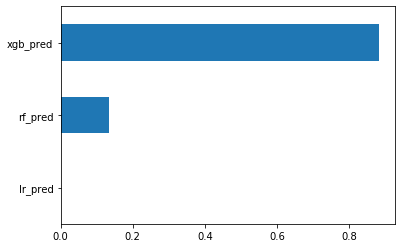

In [34]:
pd.Series(model_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

##Вывод: использование ансамблей моделей действительно улучшает качество